In [29]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

In [3]:
ff1.Cache.enable_cache('../cache')
ff1.plotting.setup_mpl()

In [4]:
year, event, event_type = 2023, 'Miami', 'FP1'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps(with_telemetry=True)
weather_data = laps.get_weather_data()

C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Miami Grand Prix - Practice 1 [v2.3.1]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with

In [5]:
driver = 'VER'
driver_laps = laps.pick_driver(driver)
low_fuel_push_laps = driver_laps[(driver_laps['LapNumber'].isin([2, 3, 6, 8, 11])) & (driver_laps['Stint'] == 1)]

In [6]:
telemetry_data = []

for _, lap in low_fuel_push_laps.iterrows():
    lap_telemetry = lap.get_telemetry()
    telemetry_data.append(lap_telemetry)

print(telemetry_data[0].columns)

Index(['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z'],
      dtype='object')


In [7]:
plot_width = 10
plot_height = 12
plot_size = [plot_width, plot_height]
title_font_size = int(1 * plot_height)  # Adjust the 0.15 multiplier to your liking
axis_label_font_size = int(1 * plot_height)  # Adjust the 0.1 multiplier to your liking
plot_title = f"{session.event.year} {session.event.EventName} - {session.name} - {driver}"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

C:\Users\getou\AppData\Local\Temp\ipykernel_5580\4235710031.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  laps_temperature = laps_temperature.append({'Lap': lap_number, 'SessionTime': lap_start_time, 'TrackTemp': closest_weather_data['TrackTemp']}, ignore_index=True)
C:\Users\getou\AppData\Local\Temp\ipykernel_5580\4235710031.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  laps_temperature = laps_temperature.append({'Lap': lap_number, 'SessionTime': lap_start_time, 'TrackTemp': closest_weather_data['TrackTemp']}, ignore_index=True)
C:\Users\getou\AppData\Local\Temp\ipykernel_5580\4235710031.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  laps_temperature = laps_temperature.append({'Lap': lap_number, 'Sessio

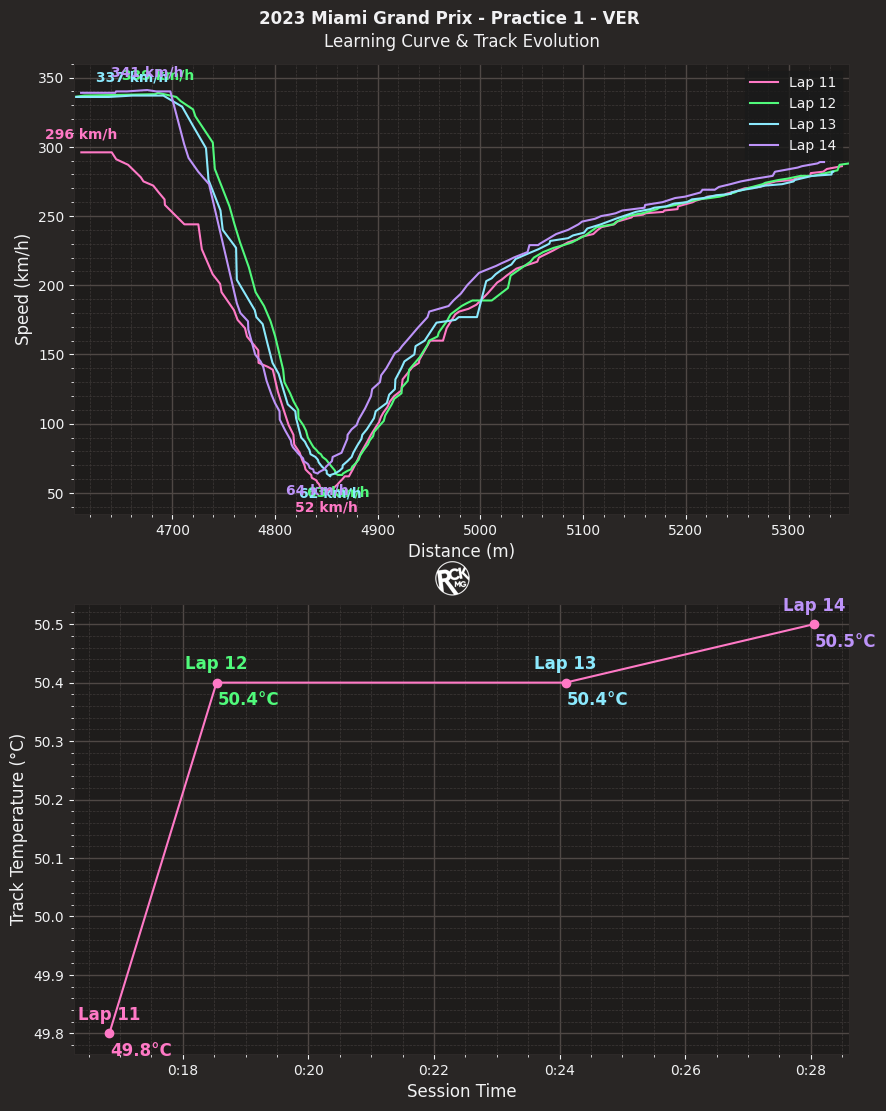

In [47]:
plt.rcParams['figure.figsize'] = plot_size
fig, ax = plt.subplots(2, 1)
fig.suptitle(plot_title, fontsize=title_font_size, fontweight='bold')
fig.subplots_adjust(top=0.935)
ax[0].set_title('Learning Curve & Track Evolution', fontsize=axis_label_font_size)

lap_number = 10
# Filter weather data for the same time range as the telemetry data
start_time = telemetry_data[0].iloc[0]['SessionTime']
end_time = telemetry_data[-1].iloc[-1]['SessionTime']
weather_data['SessionTime'] = pd.to_timedelta(weather_data['Time'])
weather_data_filtered = weather_data[(weather_data['SessionTime'] >= start_time) & (weather_data['SessionTime'] <= end_time)]

turn17_start = 4600
turn17_end = turn17_start + 1000  # Adjust this value according to the length of Turn 17

min_distance = float('inf')
max_distance = float('-inf')

temperature_color = []

for lap_telemetry in telemetry_data:
    lap_number += 1
    t17_telemetry = lap_telemetry[(lap_telemetry['Distance'] >= turn17_start) & (lap_telemetry['Distance'] <= turn17_end)]

    if not t17_telemetry.empty:
        line, = ax[0].plot(t17_telemetry['Distance'], t17_telemetry['Speed'], label=f'Lap {lap_number}')
        min_distance = min(min_distance, t17_telemetry['Distance'].min())
        max_distance = max(max_distance, t17_telemetry['Distance'].max())
        line_color = line.get_color()
        temperature_color += [line.get_color()]
        min_speed_index = t17_telemetry['Speed'].idxmin()
        max_speed_index = t17_telemetry['Speed'].idxmax()
        min_speed_data = t17_telemetry.loc[min_speed_index]
        max_speed_data = t17_telemetry.loc[max_speed_index]
        vertical_offset = (lap_number - 11) * 15
        ax[0].annotate(f"{min_speed_data['Speed']:.0f} km/h", (min_speed_data['Distance'], min_speed_data['Speed']),
                    textcoords="offset points", xytext=(0, -15), ha='center', color=line_color, fontweight='bold')
        ax[0].annotate(f"{max_speed_data['Speed']:.0f} km/h", (max_speed_data['Distance'], max_speed_data['Speed']),
                    textcoords="offset points", xytext=(0, 10), ha='center', color=line_color, fontweight='bold')

ax[0].set_xlabel('Distance (m)', fontsize=axis_label_font_size)
ax[0].set_ylabel('Speed (km/h)', fontsize=axis_label_font_size)

# Set x-axis limits
ax[0].set_xlim(min_distance, max_distance)

# Set y-axis limits
min_speed = 35
ax[0].set_ylim(min_speed, 360)

# Create a new DataFrame to store the temperature data for each lap
laps_temperature = pd.DataFrame(columns=['Lap', 'SessionTime', 'TrackTemp'])
lap_number = 10
for idx, lap_telemetry in enumerate(telemetry_data):
    lap_number += 1
    lap_start_time = lap_telemetry.iloc[0]['SessionTime']

    # Find the closest weather data point to the lap start time
    closest_weather_data = weather_data_filtered.iloc[(weather_data_filtered['SessionTime'] - lap_start_time).abs().idxmin()]
    laps_temperature = laps_temperature.append({'Lap': lap_number, 'SessionTime': lap_start_time, 'TrackTemp': closest_weather_data['TrackTemp']}, ignore_index=True)

# Plot the track temperature data
ax[1].plot(laps_temperature['SessionTime'], laps_temperature['TrackTemp'], marker='o', linestyle='-')

# Add annotations for each lap
for index, row in laps_temperature.iterrows():
    ax[1].annotate(f'Lap {row["Lap"]:.0f}', (row['SessionTime'], row['TrackTemp']), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=axis_label_font_size, fontweight='bold', color=temperature_color[index])
    ax[1].annotate(f'{row["TrackTemp"]}°C', (row['SessionTime'], row['TrackTemp']), textcoords="offset points", xytext=(23, -16), ha='center', fontsize=axis_label_font_size, fontweight='bold', color=temperature_color[index])
ax[1].set_xlabel('Session Time', fontsize=axis_label_font_size)
ax[1].set_ylabel('Track Temperature (°C)', fontsize=axis_label_font_size)

# Define the new width and height for the logo
new_width = 35
new_height = 35
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 435
logo_y = 515
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

ax[0].legend()
plt.show()